In [1]:
import numpy as np
import torch
import math
!pip install gpytorch
import gpytorch
from gpytorch.kernels.rbf_kernel import postprocess_rbf
from matplotlib import pyplot as plt

from collections import OrderedDict

     |████████████████████████████████| 286kB 21.1MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.4.0-py2.py3-none-any.whl size=477826 sha256=2c4384f9a1c35053af9a3cf76b82073e20237020bb6f724acaae258311ced8bf
  Stored in directory: /root/.cache/pip/wheels/fd/f5/39/404e1875f841e8a999e94a7efa17f6ef900298be5452b63b0c
Successfully built gpytorch


In [109]:

def function(X,noise=0):
  def func(x):
    return (math.pow((x[1]-5.1/(4*math.pow(3.14,2))*math.pow(x[0],2)+5/3.14*x[0]-6),2)+10*(1-1/(8*3.14))*math.cos(x[0])+10)*math.sin(x[2]/5)
  return torch.tensor(np.apply_along_axis(func, 1, X).reshape(-1,1),dtype = torch.float32)

def get_proj_matrix(D,d,hypersphere=0):
  A = np.random.normal(0,1,(d,D))
  if hypersphere==1:
    for row in range(d):
      N = np.linalg.norm(A[row,:])
      A[row,:] = A[row,:]/N
  return A



class AleboKernel(gpytorch.kernels.Kernel):
  def __init__(self,B):
    super().__init__(has_length=False,ard_num_dims=None,eps=0.0)
    self.d = B.shape[0]
    self.D = B.shape[1]
    self.B = B
    self.Binv = torch.pinverse(B)
    # self.dtype = B.dtype
    # self.batch_shape = batch_shape

    A = torch.qr(torch.randn(self.D,self.D))[0]
    ABinv = A[:self.d,:] @ self.Binv
    T = ABinv.t() @ ABinv
    U = torch.cholesky(T,upper = True)
    self.idx = U.nonzero().t().tolist()
    Uvec = U[self.idx]#.repeat(*batch_shape,1)
    self.register_parameter(name = "Uvec",parameter=torch.nn.Parameter(Uvec))
    
  def forward(self,x1,x2,**params):
    U_t = torch.zeros(self.Uvec.shape[:-1]+torch.Size([self.d,self.d]))
    U_t[...,self.idx[1],self.idx[0]] = self.Uvec

    z1 = x1 @ U_t
    z2 = x2 @ U_t

    return self.covar_dist(z1,z2,square_dist=True,dist_postprocess_func=postprocess_rbf,**params)

class AleboGP(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood,B):
    super().__init__(train_x, train_y, likelihood)
    self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel=AleboKernel(B=B))
    self.mean_module = gpytorch.means.ConstantMean()
  def forward(self,x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



batch_shape = torch.Size([1])
a1 = torch.linspace(-5, 10, 10)
a2 = torch.linspace(0, 15, 10)
a3 = torch.linspace(-5,5,10)
train_x = torch.zeros((10*10*10,3),dtype=torch.float32)
ctr=0
for i1 in a1:
    for i2 in a2:
        for i3 in a3:
            train_x[ctr,0] = i1
            train_x[ctr,1] = i2
            train_x[ctr,2] = i3
            ctr+=1
B = torch.tensor(get_proj_matrix(3,2,1),dtype=torch.float32)
train_x_d = (train_x @ B.t())
train_y = function(train_x)
train_y = train_y.squeeze(1)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = AleboGP(train_x_d, train_y, likelihood,B)


In [110]:
def double_derivative(i,epsilon_i,m1,m2,l1,l2,train_x,train_y,training_iter):
    '''Function which takes the models m1 and m2 (m2 is for m1+epsilon)
        and returns the double derivative for i-th component'''
    m1,l1 = train(m1,l1,train_x,train_y,training_iter)
    m2,l2 = train(m2,l2,train_x,train_y,training_iter)
    g1 = (m1.covar_module.base_kernel.Uvec.grad)
    g2 = (m2.covar_module.base_kernel.Uvec.grad)
    return (g2[i] - g1[i])/epsilon_i

def train(model,likelihood,train_x,train_y,training_iter=50):
# training_iter = 50
  model.train()
  likelihood.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


  for i in range(training_iter):
      optimizer.zero_grad()
      output = model(train_x)
  
      loss = -mll(output, train_y).sum()
      loss.backward()
      optimizer.step()
      params_dict = OrderedDict(mll.named_parameters())

  model.eval()
  likelihood.eval()

  return model,likelihood

model,likelihood = train(model,likelihood,train_x_d,train_y,1)

In [111]:
def get_r2_square(model,likelihood,train_x,train_y):
  observed_pred = likelihood(model(train_x))
  lower,upper = observed_pred.confidence_region()
  r2_square = 0
  sum_diff = 0
  for i in range(train_x.shape[0]):
    r2_square += (observed_pred.mean[i].detach().numpy()-train_y[i].numpy())**2
  sum_diff += np.sum(upper.detach().numpy())-np.sum(lower.detach().numpy())

  return r2_square,sum_diff
    
def get_best_fit_gp(train_x,train_y,n_trials=10):
  ## Use MLL if it gives poor result.
  best_state = {}
  r2_square = 1e9
  for i in range(n_trials):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = AleboGP(train_x, train_y, likelihood,B)
    model,likelihood = train(model,likelihood,train_x,train_y)
    print(model(train_x))
    r2_square_i,sum_diff_i = get_r2_square(model,likelihood,train_x,train_y)

    if r2_square_i < r2_square:
      best_state = model.state_dict()
      r2_square = r2_square_i
  
  best_likelihood =gpytorch.likelihoods.GaussianLikelihood()
  best_model = AleboGP(train_x, train_y, likelihood,B)
  best_model.state_dict(best_state)

  return best_likelihood,best_model


# def sample_U(likelihood,model,nsamp=10):
  # return list of Uvec for each model
likelihood, model = get_best_fit_gp(train_x @ B.t(),train_y)



/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))
MultivariateNormal(loc: torch.Size([1000]))


In [112]:
def get_grad(model,likelihood,x0):
  ## x0 is the model parameter at which we have to return  grad

  model.train()
  likelihood.train()


  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  mll = set_param(mll,x0)
  Uvev_0 = np.array([])
  for x in mll.named_parameters():
    param_name = x[0]
    # param_grad = 
  
  

/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


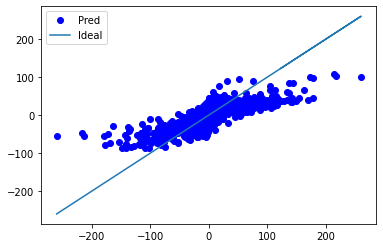

In [113]:
model.eval()
likelihood.eval()

observed_pred = likelihood(model(train_x @ B.t()))
lower,upper = observed_pred.confidence_region()


plt.plot(train_y, observed_pred.mean.detach().numpy(),'bo' ,label="Pred")
plt.plot(train_y,train_y,label='Ideal')
plt.legend()